# Importation des bibliothèques nécessaires.

In [34]:
#!/usr/bin/env python3

import sys
sys.path.insert(0, '../pyaf/py_aff3ct/build/lib')

import numpy as np
import py_aff3ct as aff3ct
import math
import time
import matplotlib.pyplot as plt
from datetime import timedelta
from tempfile import TemporaryFile

from py_aff3ct.module.py_module import Py_Module
import py_aff3ct.tools.frozenbits_generator as tool_fb
import py_aff3ct.tools.noise as tool_noise
import py_aff3ct.tools.sparse_matrix as tool_sp
import random 

# Python module (1/3) : Source.

In [35]:
class source(Py_Module):

	def generate(self, r_in, enable, delta_x, delta_y, ix_x, ix_y, x, y):
		r_in[:] 	 = self.r_in[:]
		enable[:]	 = self.enable
		ix_x[:] 	 = self.ix_x[:]
		ix_y[:] 	 = self.ix_y[:]
		x[:] 		 = self.vec_cnt // len(self.delta_y_range)
		y[:] 		 = self.vec_cnt %  len(self.delta_y_range)
		delta_x[:] 	 = self.delta_x_range[x]	
		delta_y[:] 	 = self.delta_y_range[y]	
		self.vec_cnt = self.vec_cnt + 1 	
		return 0
    
	def __init__(self, r_in, N, ix_x, ix_y): # N == len(r_in[0,:])

		Py_Module.__init__(self) # Call the aff3ct Py_Module __init__
		
		self.name   		= "source_xy"   
		self.r_in   		= r_in				
		self.delta_x_range 	= np.arange(-4,4,0.05)
		self.delta_y_range 	= np.arange(-4,4,0.05)
		self.enable 		= 1
		self.ix_x   		= ix_x 
		self.ix_y   		= ix_y 
		self.x				= 0			
		self.y				= 0						
		self.vec_cnt 		= 0 			
		self.delta_x 		= np.ndarray(shape = (1,1), dtype = np.float32)
		self.delta_y		= np.ndarray(shape = (1,1), dtype = np.float32)

		t_generate = self.create_task("generate") 	# create a task for your module

		s_r_in    = self.create_socket_out  (t_generate, "r_in"   , N		 , np.float32 ) # create an output socket for the task t_generate
		s_enable  = self.create_socket_out  (t_generate, "enable" , 1		 , np.int32   ) # create an output socket for the task t_generate
		s_delta_x = self.create_socket_out  (t_generate, "delta_x", 1		 , np.float32 )	# create an output socket for the task t_generate
		s_delta_y = self.create_socket_out  (t_generate, "delta_y", 1	 	 , np.float32 ) # create an output socket for the task t_generate
		s_ix_x    = self.create_socket_out  (t_generate, "ix_x"   , 1		 , np.int32   ) # create an output socket for the task t_generate
		s_ix_y    = self.create_socket_out  (t_generate, "ix_y"   , 1		 , np.int32   ) # create an output socket for the task t_generate
		s_x    	  = self.create_socket_out  (t_generate, "x"      , 1		 , np.int32   ) # create an output socket for the task t_generate
		s_y    	  = self.create_socket_out  (t_generate, "y"   	  , 1		 , np.int32   ) # create an output socket for the task t_generate

		self.create_codelet(t_generate, lambda slf, lsk, fid: slf.generate(lsk[s_r_in],lsk[s_enable],lsk[s_delta_x],lsk[s_delta_y],lsk[s_ix_x],lsk[s_ix_y],lsk[s_x], lsk[s_y]))

# Python module (2/3) : Add.

In [36]:
class add_impulses(Py_Module):

	def add(self, ix_x, ix_y, delta_x, delta_y, enable, r_in, r_out):
		r_out[0,:] = r_in[:]
		if(enable == 1):
			r_out[0, ix_x] = delta_x
			r_out[0, ix_y] = delta_y
		return 0
    
	def __init__(self, N):

		Py_Module.__init__(self) # Call the aff3ct Py_Module __init__
		self.name = "add_impulses"   # Set your module's name

		t_add = self.create_task("add") # create a task for your module
        
		s_ix_x    = self.create_socket_in  (t_add, "ix_x"   , 1, np.int32   ) # create an input socket for the task t_add
		s_ix_y    = self.create_socket_in  (t_add, "ix_y"   , 1, np.int32   ) # create an input socket for the task t_add
		s_delta_x = self.create_socket_in  (t_add, "delta_x", 1, np.float32 ) # create an input socket for the task t_add
		s_delta_y = self.create_socket_in  (t_add, "delta_y", 1, np.float32 ) # create an input socket for the task t_add
		s_enable  = self.create_socket_in  (t_add, "enable" , 1, np.int32   ) # create an input socket for the task t_add
		s_r_in    = self.create_socket_in  (t_add, "r_in"   , N, np.float32 ) # create an input socket for the task t_add
		s_r_out   = self.create_socket_out (t_add, "r_out"  , N, np.float32 ) # create an output socket for the task t_add
		    
		self.create_codelet(t_add, lambda slf, lsk, fid: slf.add(lsk[s_ix_x], lsk[s_ix_y], lsk[s_delta_x], lsk[s_delta_y], lsk[s_enable], lsk[s_r_in], lsk[s_r_out])) # create codelet

# Python module (3/3) : Display.

In [37]:
class display_impulses(Py_Module):

	def display(self, x, y, BE, enable):#heat_map et h_ix sont des constantes
		if enable!=0:
			#self.map[self.H-self.ytempo-1,self.xtempo] = np.array([BE*self.heat_map[self.h_ix,0], BE*self.heat_map[self.h_ix,1], BE*self.heat_map[self.h_ix,2]])
			
			self.map[self.H-y-1,x,0] = BE*self.heat_map[self.h_ix,0]
			self.map[self.H-y-1,x,1] = BE*self.heat_map[self.h_ix,1]
			self.map[self.H-y-1,x,2] = BE*self.heat_map[self.h_ix,2]
			mnt2.reset()
			
			if self.xtempo==0:
				self.xtempo = 159
				if self.ytempo <159:
					self.ytempo+=1
				else:
					self.toggle_done()
			else:
				self.xtempo-=1
			
		return 0
    
	def __init__(self, H, W, heat_map, h_ix):
		
		Py_Module.__init__(self) # Call the aff3ct Py_Module __init__

		self.name 		= "display_impulses"   # Set your module's name
		self.xtempo 	= 0
		self.ytempo 	= 0
		self.heat_map = heat_map
		self.h_ix	 	= h_ix
		self.H 			= H
		self.W 			= W
		self.map		= np.zeros( (H,W,3), dtype=np.uint8)

		t_dis = self.create_task("display") # create a task for your module

		s_x 	 = self.create_socket_in  (t_dis, "x"   	, 1, np.int32   ) # create an input socket for the task t_dis
		s_y		 = self.create_socket_in  (t_dis, "y"   	, 1, np.int32   ) # create an input socket for the task t_dis
		s_BE	 = self.create_socket_in  (t_dis, "BE"   	, 1, np.int32   ) # create an input socket for the task t_dis
		s_enable = self.create_socket_in (t_dis, "enable"  , 1, np.int32   ) # create an input socket for the task t_dis
		
		self.create_codelet(t_dis, lambda slf, lsk, fid: slf.display(lsk[s_x], lsk[s_y], lsk[s_BE], lsk[s_enable])) # create codelet


# Définition des paramètres.

In [38]:
#N = 576 
#K = 288
# K = 64*2
# N = 3*K
N = 128
K = 64

ebn0_min = 2.7
ebn0_max = 2.71
ebn0_step = 0.2

ebn0 = np.arange(ebn0_min,ebn0_max,ebn0_step)
esn0 = ebn0 + 10 * math.log10(K/N)
sigma_vals = 1/(math.sqrt(2) * 10 ** (esn0 / 20))

delta_x_range = np.arange(-4,4,0.05)
delta_y_range = np.arange(-4,4,0.05)

W = len(delta_x_range)
H = len(delta_y_range)

code_type = "polar"

# Définition des modules de la séquence (1/2).

In [39]:
if(code_type == "turbo"):
	# Build DVBS-RCS2 Turbo encoder.
	enc_n = aff3ct.module.encoder.Encoder_RSC_DB(K,2*K,standard='DVB-RCS1')
	enc_i = aff3ct.module.encoder.Encoder_RSC_DB(K,2*K,standard='DVB-RCS1')

	# Build DVBS-RCS2 Interleaver.
	itl_core = aff3ct.tools.interleaver_core.Interleaver_core_ARP_DVB_RCS1(K//2)
	itl_bit  = aff3ct.module.interleaver.Interleaver_int32(itl_core)
	itl_llr  = aff3ct.module.interleaver.Interleaver_float(itl_core)
	enc = aff3ct.module.encoder.Encoder_turbo_DB(K,N,enc_n,enc_i,itl_bit)

	# Build DVBS-RCS2 Trubo decoder.
	trellis_n = enc_n.get_trellis()
	trellis_i = enc_i.get_trellis()

	dec_n = aff3ct.module.decoder.Decoder_RSC_DB_BCJR_DVB_RCS1(K,trellis_n)
	dec_i = aff3ct.module.decoder.Decoder_RSC_DB_BCJR_DVB_RCS1(K,trellis_i)
	dec   = aff3ct.module.decoder.Decoder_turbo_DB(K,N,8,dec_n,dec_i,itl_llr)

elif(code_type == "polar"): #polar

	fbgen = tool_fb.Frozenbits_generator_GA_Arikan(K, N)
	esn0 = 3.0 + 10 * math.log10(K/N)
	sigma = 1/(math.sqrt(2) * 10 ** (esn0 / 20))
	noise = tool_noise.Sigma(sigma)
	fbgen.set_noise(noise)
	frozen_bits = fbgen.generate()

	enc  = aff3ct.module.encoder.Encoder_polar_sys      (K,N,frozen_bits)     # Build the encoder
	#dec  = aff3ct.module.decoder.Decoder_polar_SC_fast_sys(K,N,frozen_bits)   # Build the decoder
	#dec = aff3ct.module.decoder.Decoder_polar_SCL_MEM_fast_sys(K,N,8,frozen_bits)
	I = 10
	dec = aff3ct.module.decoder.Decoder_polar_SCAN_naive_sys(K, N, I, frozen_bits)
elif(code_type == "ldpc"):
	I = 10
	# H   = tool_sp.alist.read("../py_aff3ct/lib/aff3ct/conf/dec/LDPC/WIMAX_288_576.alist")
	# H   = tool_sp.alist.read("../py_aff3ct/lib/aff3ct/conf/dec/LDPC/10GBPS-ETHERNET_1723_2048.alist")
	H = tool_sp.alist.read("../py_aff3ct/lib/aff3ct/conf/dec/LDPC/CCSDS_64_128.alist")
	

	N   = H.shape[0]
	m   = H.shape[1]
	K   = N - m
	enc  = aff3ct.module.encoder.Encoder_LDPC_from_H    (K, N, H)                                                   # Build the encoder
	dec  = aff3ct.module.decoder.Decoder_LDPC_BP_horizontal_layered_inter_NMS (K, N, I, H, enc.get_info_bits_pos()) # Build the decoder
else:
	K = 106
	N = 127
	t = 3
	poly = aff3ct.tools.BCH_polynomial_generator(N, t)
	enc = aff3ct.module.encoder.Encoder_BCH(K, N, poly)
	dec = aff3ct.module.decoder.Decoder_BCH_std(K, N, poly)

src  = aff3ct.module.source.Source_random_fast(K, 12)
mdm  = aff3ct.module.modem.Modem_BPSK_fast(N)

gen = aff3ct.tools.Gaussian_noise_generator_implem.FAST
chn = aff3ct.module.channel.Channel_AWGN_LLR(N, gen)
mnt = aff3ct.module.monitor.Monitor_BFER_AR(K, 1)

sigma      = np.ndarray(shape = (1,1),  dtype = np.float32)
noisy_vec  = np.ndarray(shape = (1,N),  dtype = np.float32)
vec_src    = np.ndarray(shape = (1,K),  dtype = np.int32)
r_in       = np.ndarray(shape = (1,N),  dtype = np.float32)

map = np.zeros( (H,W,3), dtype=np.uint8)
src.reset()

from datetime import datetime

seed = random.randint(0, 123456789)
src.set_seed(seed+1)
chn.set_seed(seed)

# Séquence 1 : génération des vecteur "noisy_vec" et "vec_src".

In [40]:
src["generate   ::U_K  "] = enc["encode       ::U_K "]
enc["encode     ::X_N  "] = mdm["modulate     ::X_N1"]
mdm["modulate   ::X_N2 "] = chn["add_noise    ::X_N "]
chn["add_noise  ::Y_N  "] = mdm["demodulate   ::Y_N1"]
mdm["demodulate ::Y_N2 "] = dec["decode_siho  ::Y_N "]
src["generate   ::U_K  "] = mnt["check_errors ::U   "]
dec["decode_siho::V_K  "] = mnt["check_errors ::V   "]
chn["add_noise  ::CP   "].bind( sigma  )
mdm["demodulate ::CP   "].bind( sigma  )

seq1 = aff3ct.tools.sequence.Sequence(src("generate"),  1)
seq1.export_dot("chaos.dot")

The use of parenthesis for accessing tasks is deprecated, use brackets instead.


# Chargement des vecteurs "noisy_vec" et "vec_src".

In [41]:
load_file = False

if(load_file == False):
	for i in range(len(sigma_vals)):
		sigma[:] = sigma_vals[i]
		seq1.exec()		
		print("be=",mnt.get_n_be())
		print("fe=",mnt.get_n_fe())
		mnt.reset()
	with open('noisy_cw.npy', 'wb') as f:
		np.save(f, dec['decode_siho::Y_N'][:])
		np.save(f, src['generate::U_K'][:])

with open('noisy_cw.npy', 'rb') as f:
	r_in = np.load(f)
	vec_src = np.load(f)

be= 2
fe= 1


# Paramètres pour la séquence 2.

In [42]:
# Pour le module source
ix_x    = np.ndarray(shape = (1,1),  dtype = np.int32  )
ix_y    = np.ndarray(shape = (1,1),  dtype = np.int32  )
ix_x[:] = 1  # np.random.randint(N)
ix_y[:] = 20 # (ix_x[:]+5) % N 

# Pour le module display
heat_map = np.ndarray(shape=(5,3),dtype = np.uint8)
heat_map[0] = [4,8,16]
heat_map[1] = [16,8,4]
heat_map[2] = [8,16,4]
heat_map[3] = [100,50,25]
heat_map[4] = [16,16,16]
h_ix = 0

# Séquence 2 : source + adi + decode + monitor + display.

In [43]:
my_src = source(r_in, N, ix_x, ix_y)
adi    = add_impulses(N)
dec2   = aff3ct.module.decoder.Decoder_polar_SCAN_naive_sys(K, N, I, frozen_bits)
mnt2   = aff3ct.module.monitor.Monitor_BFER(K, 1)
dis    = display_impulses(H, W, heat_map, h_ix)

my_src["generate :: r_in   "   ] = adi   ["add :: r_in   "     ] 
my_src["generate :: enable "   ] = adi   ["add :: enable "     ]   
my_src["generate :: delta_x"   ] = adi   ["add :: delta_x"     ]
my_src["generate :: delta_y"   ] = adi   ["add :: delta_y"     ]
my_src["generate :: ix_x   "   ] = adi   ["add :: ix_x   "     ]
my_src["generate :: ix_y   "   ] = adi   ["add :: ix_y   "     ]
adi   ["add           :: r_out"] = dec2  ["decode_siho  ::Y_N" ]
dec2  ["decode_siho   :: V_K  "] = mnt2  ["check_errors2::V"   ]
dis   ["display :: x"          ] = my_src["generate :: x"      ]
dis   ["display :: y"          ] = my_src["generate :: y"      ]
dis   ["display :: BE "        ] = mnt2  ["check_errors2 :: BE"]
dis   ["display :: enable"     ] = my_src["generate :: enable" ] 

mnt2  ["check_errors2:: U    " ].bind(vec_src)

seq2 = aff3ct.tools.sequence.Sequence(my_src("generate"),  1)
seq2.export_dot("full_module.dot")

The use of parenthesis for accessing tasks is deprecated, use brackets instead.


# Exécution de la séquence 2.

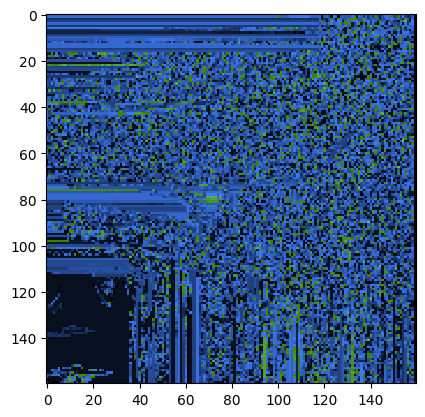

In [44]:
seq2.exec()
plt.imshow(dis.map, interpolation='none')
plt.show()

## Il semblerait qu'il y ai un offset de -1 selon x